In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

#from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print("Data size (rows, columns): "+ str(molecular_descriptors.shape))
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print("Data size after first reduction (rows, columns): "+ str(molecular_descriptors.shape))
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print("Data size after second reduction (rows, columns): "+ str(molecular_descriptors.shape))
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        print('There is issue with the target values...')
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold, verbose = False):
    
    if verbose:
        correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), 
                                         columns=["molecular descriptor name"])
        print(correlation_table.head())
        correlation_to_ak_cyt = []
        for mol_desc in correlation_table['molecular descriptor name']:
            x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), 
                            np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
            x = x.tolist()[0][1]
            correlation_to_ak_cyt.append(x)
        correlation_table['corr_value'] = correlation_to_ak_cyt
        print(correlation_table.head())
        correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
        print(correlation_table[:-1].head())
    
        mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
        print(mol_desc_best_corr.head())
        table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
        print(table_with_descriptors_to_be_used.head())
    else:
        correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), 
                                         columns=["molecular descriptor name"])
        
        correlation_to_ak_cyt = []
        for mol_desc in correlation_table['molecular descriptor name']:
            x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), 
                            np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
            x = x.tolist()[0][1]
            correlation_to_ak_cyt.append(x)
        correlation_table['corr_value'] = correlation_to_ak_cyt
        
        correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
        
    
        mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
        
        table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
        
        
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 81) 
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 60)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 28)]
    
    test_data = test123.iloc[[0, 1, 3]] #It allows to get 3 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data, verbose = False):
    
    
    if verbose:
        X = data[features['molecular descriptor name']]
        y = data['Aktywność cytoprotekcyjna [%]']
        randfor = RandomForestRegressor(random_state=15, n_estimators=20)
        randfor.fit(X, y)
        print("Return the coefficient of determination of the prediction: ")
        print(randfor.score(test_data[features['molecular descriptor name']], test_data['Aktywność cytoprotekcyjna [%]']))
        pred = randfor.predict(X)
        print("R^2 score: "+ str(r2_score(y, pred)))
        sqrt_r2 = np.sqrt(r2_score(y, pred))
        training_data_r2 = r2_score(y, pred)
        print('Correlation coefficient: '+ str(sqrt_r2))
        print("Test data - unseen during training:")
        pred = randfor.predict(test_data[features['molecular descriptor name']])
        print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
        sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
        print('Correlation coefficient: '+ str(sqrt_r2))
        print(pred)
        print(test_data['Aktywność cytoprotekcyjna [%]']) 
        test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])
    else:
        X = data[features['molecular descriptor name']]
        y = data['Aktywność cytoprotekcyjna [%]']
        randfor = RandomForestRegressor(random_state=15, n_estimators=20)
        randfor.fit(X, y)
        pred = randfor.predict(X)
        sqrt_r2 = np.sqrt(r2_score(y, pred))
        training_data_r2 = r2_score(y, pred)
        pred = randfor.predict(test_data[features['molecular descriptor name']])
        sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
        test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])               
    
    return randfor, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization, verbose = False):
    
    if standarization == True:
        
        if verbose:
            print("I am doing standarization...")
        else:
            pass
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold, verbose)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_, verbose)
        
    elif standarization == False:
        
        if verbose:
            print("I am not doing standarization...")
        else:
            pass
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold, verbose)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_, verbose)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/Indole_-_cytoprotekcja_.xlsx')

 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:01<00:00, 21.19it/s]

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 22.51it/s]


Data size (rows, columns): (44, 1613)
Data size after first reduction (rows, columns): (44, 1613)
Data size after second reduction (rows, columns): (44, 1613)


In [10]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False, True)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520        

In [11]:
without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']])

array([79.6  , 80.6  , 72.9  , 65.65 , 68.375, 68.3  , 65.075, 79.   ,
       30.5  , 69.7  , 32.8  , 75.375, 48.475, 16.5  , 52.025, 54.9  ,
       74.5  , 72.45 , 78.6  , 82.9  , 71.275, 61.7  , 30.75 , 48.85 ,
       59.45 , 50.9  , 80.275, 56.425, 58.   , 68.9  , 71.05 , 75.85 ,
       38.3  , 52.8  , 47.05 , 10.75 , 65.5  , 92.75 , 92.1  , 89.05 ,
       86.05 , 85.05 , 83.65 , 74.35 ])

In [12]:
xs = r2_score(without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [13]:
xs

0.6087214131582633

In [14]:
np.sqrt(xs)

0.7802060068714309

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


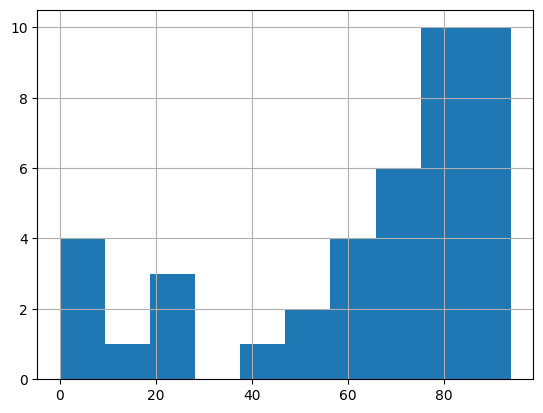

In [15]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [16]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 12


In [17]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
456,BCUTare-1l,0.345707,0.345707
520,ETA_dEpsilon_D,0.412783,0.412783
829,NaaNH,0.386873,0.386873
831,NaaS,-0.343855,0.343855
899,SaaNH,0.359872,0.359872
901,SaaS,-0.343855,0.343855
913,SlogP_VSA1,0.338615,0.338615
1030,VR1_A,-0.339451,0.339451
1040,VR2_A,-0.339146,0.339146
1126,n6HRing,0.362058,0.362058


In [18]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.33, True, True)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520            

In [19]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([35.225, 35.225, 35.225, 35.225, 35.225, 35.225, 35.225, 35.225,
       35.225, 35.225, 35.225, 35.225, 34.925, 35.225, 34.925, 35.575,
       35.225, 35.225, 35.225, 35.225, 35.225, 35.225, 35.225, 35.225,
       35.225, 35.225, 35.225, 34.925, 35.225, 35.225, 35.225, 35.225,
       35.225, 35.225, 35.225, 35.225, 35.225, 35.825, 35.825, 35.825,
       35.825, 35.825, 35.825, 35.225])

In [20]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [21]:
xs

-29198.489454651117

## Search inside correlation space

In [22]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))


In [23]:
df_without_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])

In [24]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list

In [25]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,0.841600,-22.050122,46
1,0.26,0.859594,-17.406226,38
2,0.27,0.868985,-7.646567,30
3,0.28,0.858742,-153.567121,28
4,0.29,0.863927,0.214323,26
5,0.30,0.856233,-3.986841,21
6,0.31,0.849133,-0.126333,20
7,0.32,0.843389,-27.790331,15
8,0.33,0.825518,-0.686247,12
9,0.34,0.815986,0.160470,9


In [26]:
step = 0.01
initial_step = 0.25
last_step = 0.4
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, True, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))

In [27]:
df_with_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])
df_with_standarization['Training data R^2 score'] = second_list
df_with_standarization['Test data R^2 score'] = third_list
df_with_standarization['Number of features'] = f_list

In [28]:
df_with_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.25,0.839323,-23.474845,46
1,0.26,0.852987,-38.930669,38
2,0.27,0.865430,-7.009749,30
3,0.28,0.860472,-136.103637,28
4,0.29,0.862563,0.521087,26
5,0.30,0.845632,-8.798090,21
6,0.31,0.853752,0.153495,20
7,0.32,0.836654,-10.152481,15
8,0.33,0.822640,-0.225024,12
9,0.34,0.830297,-0.081028,9


## Plots

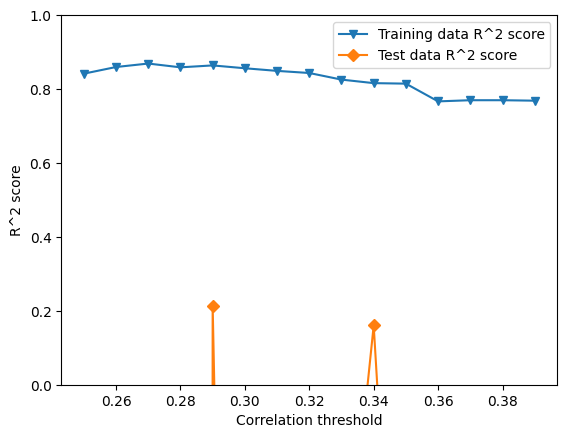

In [29]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Training data R^2 score'], label = "Training data R^2 score", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Test data R^2 score'], label = "Test data R^2 score", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R^2 score')
plt.ylim([0, 1])
plt.show()

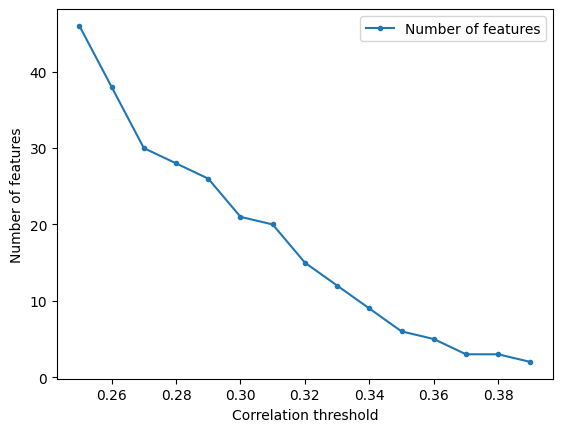

In [30]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

# sqrt(R^2)

In [31]:
df_without_standarization['train R value'] = [np.sqrt(x) for x in df_without_standarization['Training data R^2 score']]

In [32]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,train R value
0,0.25,0.841600,-22.050122,46,0.917388
1,0.26,0.859594,-17.406226,38,0.927143
2,0.27,0.868985,-7.646567,30,0.932194
3,0.28,0.858742,-153.567121,28,0.926683
4,0.29,0.863927,0.214323,26,0.929477
5,0.30,0.856233,-3.986841,21,0.925329
6,0.31,0.849133,-0.126333,20,0.921484
7,0.32,0.843389,-27.790331,15,0.918362
8,0.33,0.825518,-0.686247,12,0.908580
9,0.34,0.815986,0.160470,9,0.903319


In [33]:
xcz = []
for element in df_without_standarization['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

In [34]:
xcz

[0, 0, 0, 0, 0.462949980220314, 0, 0, 0, 0, 0.40058708966905804, 0, 0, 0, 0, 0]

In [35]:
df_without_standarization['test R value'] = xcz

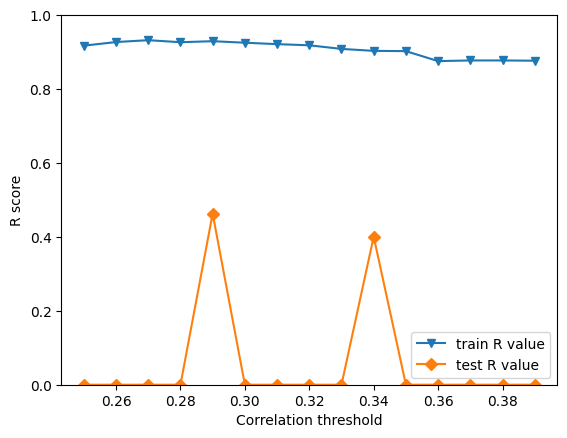

In [36]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['train R value'], label = "train R value", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

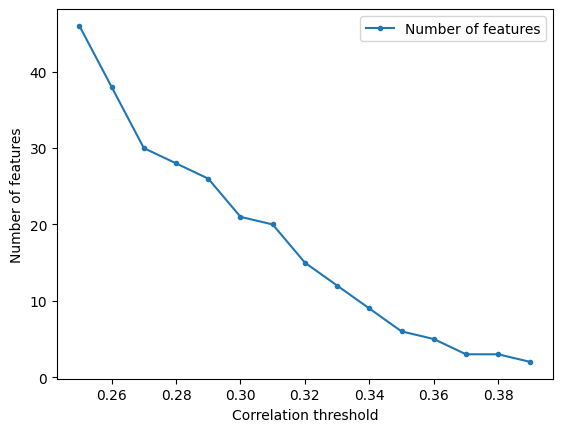

In [37]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [38]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False, True)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z   -0.105872
1                  AATS0are    0.160494
2                    AATS0d   -0.005044
3                   AATS0dv    0.121256
4                    AATS0i    0.140698
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z   -0.105872                    0.105872
1                  AATS0are    0.160494                    0.160494
2                    AATS0d   -0.005044                    0.005044
3                   AATS0dv    0.121256                    0.121256
4                    AATS0i    0.140698                    0.140698
    molecular descriptor name  corr_value  absolute correlation value
456                BCUTare-1l    0.345707                    0.345707
520        

In [39]:
final_model[0].estimators_

[DecisionTreeRegressor(max_features=1.0, random_state=1498160584),
 DecisionTreeRegressor(max_features=1.0, random_state=1346817781),
 DecisionTreeRegressor(max_features=1.0, random_state=768352140),
 DecisionTreeRegressor(max_features=1.0, random_state=392366725),
 DecisionTreeRegressor(max_features=1.0, random_state=233488247),
 DecisionTreeRegressor(max_features=1.0, random_state=476682624),
 DecisionTreeRegressor(max_features=1.0, random_state=1552795804),
 DecisionTreeRegressor(max_features=1.0, random_state=1368427163),
 DecisionTreeRegressor(max_features=1.0, random_state=1182837959),
 DecisionTreeRegressor(max_features=1.0, random_state=1832416971),
 DecisionTreeRegressor(max_features=1.0, random_state=128850005),
 DecisionTreeRegressor(max_features=1.0, random_state=107172470),
 DecisionTreeRegressor(max_features=1.0, random_state=1313911727),
 DecisionTreeRegressor(max_features=1.0, random_state=1384259805),
 DecisionTreeRegressor(max_features=1.0, random_state=1307707409),
 

In [40]:
#for x, decision_tree in enumerate(final_model[0].estimators_):
    #plt.figure(figsize=(10,8), dpi=150)
    #plot_tree(decision_tree, feature_names=list(final_model[4]['molecular descriptor name']))
    #plt.savefig('Random_forest/random_forest'+str(x)+'.svg')

In [41]:
final_model[4]

,molecular descriptor name,corr_value,absolute correlation value
456,BCUTare-1l,0.345707,0.345707
520,ETA_dEpsilon_D,0.412783,0.412783
829,NaaNH,0.386873,0.386873
831,NaaS,-0.343855,0.343855
899,SaaNH,0.359872,0.359872
901,SaaS,-0.343855,0.343855
913,SlogP_VSA1,0.338615,0.338615
1030,VR1_A,-0.339451,0.339451
1040,VR2_A,-0.339146,0.339146
1126,n6HRing,0.362058,0.362058


In [42]:
# save
joblib.dump(final_model[0], "random_forest_model.joblib")
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("random_forest_model.joblib")

In [43]:
loaded_rf.predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']])

array([79.6  , 80.6  , 72.9  , 65.65 , 68.375, 68.3  , 65.075, 79.   ,
       30.5  , 69.7  , 32.8  , 75.375, 48.475, 16.5  , 52.025, 54.9  ,
       74.5  , 72.45 , 78.6  , 82.9  , 71.275, 61.7  , 30.75 , 48.85 ,
       59.45 , 50.9  , 80.275, 56.425, 58.   , 68.9  , 71.05 , 75.85 ,
       38.3  , 52.8  , 47.05 , 10.75 , 65.5  , 92.75 , 92.1  , 89.05 ,
       86.05 , 85.05 , 83.65 , 74.35 ])

In [44]:
molecular_descriptors_df['Aktywność cytoprotekcyjna [%]']

0     81.0
1     84.0
2     70.0
3     69.0
4     68.5
5     60.0
6     60.0
7     91.0
8      0.0
9     82.0
10     0.0
11    83.0
12    48.0
13     0.0
14    28.0
15    55.0
16    81.0
17    77.0
18    76.0
19    85.0
20    86.0
21    72.0
22    17.0
23    62.0
24    80.0
25    28.0
26    92.0
27    61.0
28    64.0
29    76.0
30    84.0
31    87.0
32    28.0
33    46.0
34    24.0
35     0.0
36    67.0
37    94.0
38    93.0
39    90.0
40    87.0
41    86.0
42    82.0
43    73.0
Name: Aktywność cytoprotekcyjna [%], dtype: float64

In [45]:
xsz = r2_score(loaded_rf.predict(molecular_descriptors_df[hist2['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])
xsz

0.6087214131582633

In [46]:
np.sqrt(xsz)

0.7802060068714309

## Predict target feature

In [ ]:
New_approach is developed...

In [ ]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')

In [ ]:
predicted_activity = loaded_rf.predict(to_prediction[final_model[4]['molecular descriptor name']])

In [ ]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_indole_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [ ]:
print(len(smiles))
print(len(predicted_activity))

In [ ]:
save_to_df.head()

In [ ]:
save_to_df['Predicted activity'] = predicted_activity

In [ ]:
save_to_df.head()

In [ ]:
save_to_df.to_excel('../Data/Predicted_random_forest.xlsx')